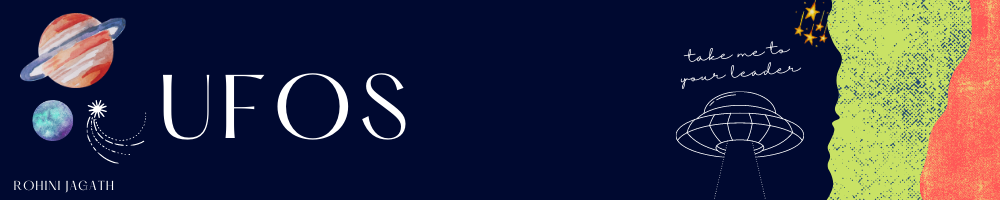

# UFO Sightings Exploratory Data Analysis

Unidentified Flying Objects (UFOs) is the term used to describe aerial phenomena that cannot be explained scientifically. The term UFO is commonly used to describe observations or events of alien / extraterrestrial origin. Having long been an X-Files fan (sneaking out of bed to watch Agent Fox and Agent Scully investigate these phenomena) and with the recent release of official video footage of UFOs by the Pentagon, an exploration of these sightings seems appropriate.

This dataset contains over 80,000 reports of UFO sightings over the last century and is freely available from Kaggle.

*Beam me up, Scotty.*

# Import Packages

In [1]:
# general imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import itertools
import time
import re

# visualizations
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
%matplotlib inline
import geopandas
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

C:\Users\User-PC\Documents\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Data

In [2]:
ufos = pd.read_csv('scrubbed.csv', low_memory=False)

In [3]:
ufos.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


In [4]:
ufos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              80332 non-null  object 
 1   city                  80332 non-null  object 
 2   state                 74535 non-null  object 
 3   country               70662 non-null  object 
 4   shape                 78400 non-null  object 
 5   duration (seconds)    80332 non-null  object 
 6   duration (hours/min)  80332 non-null  object 
 7   comments              80317 non-null  object 
 8   date posted           80332 non-null  object 
 9   latitude              80332 non-null  object 
 10  longitude             80332 non-null  float64
dtypes: float64(1), object(10)
memory usage: 6.7+ MB


# Data Description
## Data Structure & Types

The data comprises 80332 observations. Each review has the following fields:
- 'datetime' - date of the sighting
- 'city' - city in which the sighting occured
- 'state' - state in which the sighting occured
- 'country' - country in which the sighting occured
- 'shape' - shape of the ufo phenomenon 
- 'duration (seconds)' - duration of the sighting/event in seconds
- 'duration (hours/min)' - duration of the sighting/event in hours/minutes
- 'comments' - comment describing the incident
- 'date posted'- date the event was posted/reported
- 'latitude' - latitude of the sighting location
- 'longitude' - latitude of the sighting location

Almost all variables require conversion to an appropritate datatype.

In [5]:
# drop irrelavant columns
ufos.drop(['duration (hours/min)'], axis=1, inplace=True)

# fill null values for state, country, city and comment with 'unknown'
ufos[['state', 'city', 'country', 'comments']] = ufos[['state', 'city', 'country', 'comments']].fillna('unknown')

# convert date columns to datetime
ufos['datetime'] = ufos.datetime.str.replace('24:00', '00:00')
ufos['datetime'] = pd.to_datetime(ufos['datetime'], errors='coerce')
ufos['date posted'] = pd.to_datetime(ufos['date posted'], errors='coerce')

# convert duration and latitude to int
ufos['duration (seconds)'] = ufos['duration (seconds)'].str.replace("`", "")
ufos['duration (seconds)'] = ufos['duration (seconds)'].astype(float)
ufos['latitude'] = ufos['latitude'].str.replace("33q.200088", "33.200088")
ufos['latitude'] = ufos['latitude'].astype(float)

# drop null values
ufos.dropna(inplace=True)

In [6]:
ufos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78400 entries, 0 to 80331
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   datetime            78400 non-null  datetime64[ns]
 1   city                78400 non-null  object        
 2   state               78400 non-null  object        
 3   country             78400 non-null  object        
 4   shape               78400 non-null  object        
 5   duration (seconds)  78400 non-null  float64       
 6   comments            78400 non-null  object        
 7   date posted         78400 non-null  datetime64[ns]
 8   latitude            78400 non-null  float64       
 9   longitude           78400 non-null  float64       
dtypes: datetime64[ns](2), float64(3), object(5)
memory usage: 6.6+ MB


# Feature Engineering

The features to be created for exploration centre around the sighting dates, sighting duration, dates the sightings were posted and the text or comment accompanying the sighting post.

In [7]:
# time features
ufos['sighting_year'] = ufos['datetime'].dt.year
ufos['sighting_month'] = ufos['datetime'].dt.month
ufos['posted_year'] = ufos['date posted'].dt.year
ufos['time_lapse'] = (ufos['date posted'] - ufos['datetime']).dt.days

# categorise duration into groups using np.digitise
bins = [0, 900, 1800, 2700, 3600]
names = ['<15mins', '15-30mins', '30-45mins', '45-60mins','>60mins']
cat = dict(enumerate(names, 1))
ufos['timecategory'] = np.vectorize(cat.get)(np.digitize(ufos['duration (seconds)'],
                                                        bins))

ufos = ufos.sort_values(by=['timecategory'])

# text features
ufos['characters'] = ufos.comments.apply(len)
ufos['word_count'] = ufos.comments.str.split().apply(len)
ufos['av_word_length'] = ufos['characters']/ufos['word_count']

# clean comment
ufos['clean_comment'] = ufos.comments.str.lower()
ufos['clean_comment'] = ufos.clean_comment.str.replace("[^a-z]", " ")
# remove punctutation and noise
ufos['clean_comment'] = (ufos.clean_comment.apply
                         (lambda x: ' '.join
                          ([word for word in x.split() if len(word) > 2]))) 

# Exploratory Data Analysis

## Number of Sightings by Year

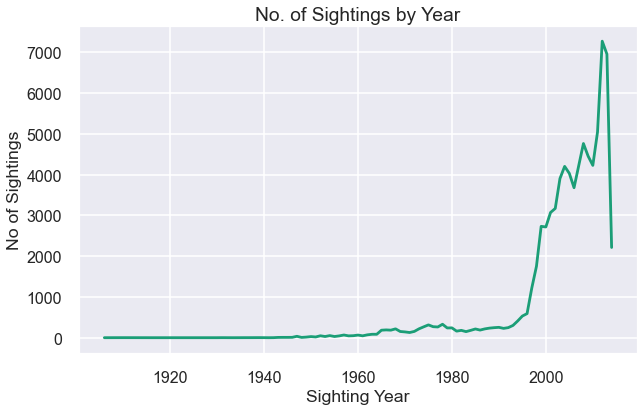

In [8]:
# group by year and count sightings per year
df = (ufos.sort_values(by='sighting_year',ascending=False).
      groupby(['sighting_year']).datetime.count())
# create plot of release years & ratings
sns.set()
style.use('seaborn-poster')
plt.figure(figsize=(10, 5))
df.plot(kind='line', colormap='Dark2', figsize=(10, 6))
plt.title('No. of Sightings by Year')
plt.xlabel('Sighting Year')
plt.ylabel('No of Sightings')
plt.show()

#### Observations:
    
- The number of sightings steadily increases from the first report in 1906 to 2014. A Notable and rapid increase in sightings occurs from the 1900 onward, peaking in 2012 (7276 sightings) 
- A decreasing trend is noted from 2012 onward. The marked decrease from 2013 to 2014 is due to 2014 only containing observations for the first 5 months of the year - incomplete data for this year.
- Sightings from the year 2000 onward reflect and ebb and flow pattern showing fluctations in the number of sighting reports in recent times.

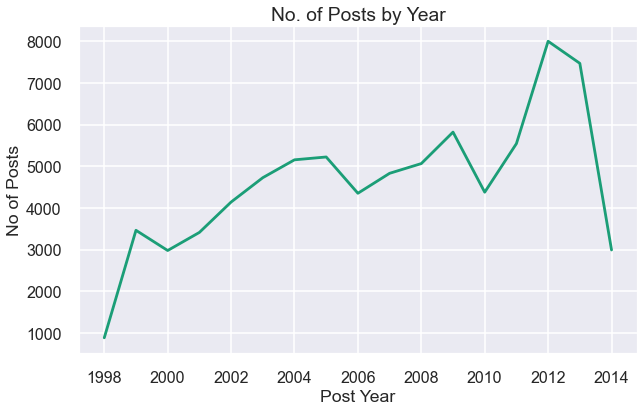

In [9]:
# group by year and count sightings per year
df = (ufos.sort_values(by='posted_year',ascending=False).
      groupby(['posted_year']).datetime.count())


# create plot of post years & sightings
sns.set()
style.use('seaborn-poster')
plt.figure(figsize=(10, 5))
df.plot(kind='line', colormap='Dark2', figsize=(10, 6))
plt.title('No. of Posts by Year')
plt.xlabel('Post Year')
plt.ylabel('No of Posts')
plt.show()

#### Observations
- Posting of events or sightings starts in the late 1990s. Cataloging of sightings before this period appears to be non-existent and only occurs after 1998.
- Posting peaks in 2012 and coincides with the peak in sightings in 2012. 

## Distribution of Sightings by Country

In [10]:
# read world map
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
print("Geometry Column Name : ", world.geometry.name)
print("Dataset Size : ", world.shape)

Geometry Column Name :  geometry
Dataset Size :  (177, 6)


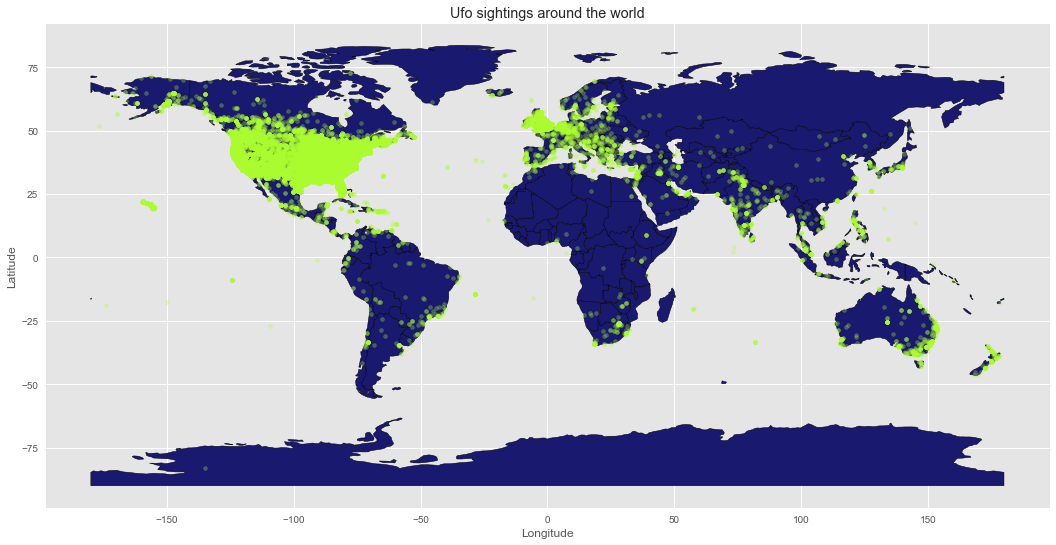

In [11]:
# plot sightings per country map
with plt.style.context(("seaborn", "ggplot")):
    world.plot(figsize=(18,10),
               color="midnightblue",
               edgecolor = "black");

    plt.scatter(ufos['longitude '], ufos['latitude'], s=15, color="greenyellow", alpha=0.3)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Ufo sightings around the world");

#### Observations:
- The largest concentration of sightings is in North America, followed by Europe, South Asia, South East Asia and Australia.
- The African continent has the lowest density of sightings, with the majority of sightings observed in South Africa.
- For continents and countries with a lower density of sightings, sightings are clearly more commonly observed in coastal areas (Autralia, Asia, South America). This is attributed to higher populations and levels of urbanisation in these regions.
- Some sightings are observed over international waters.

## Exploring Shape

Text(0.5, 1.0, 'No of Sightings by UFO Shape')

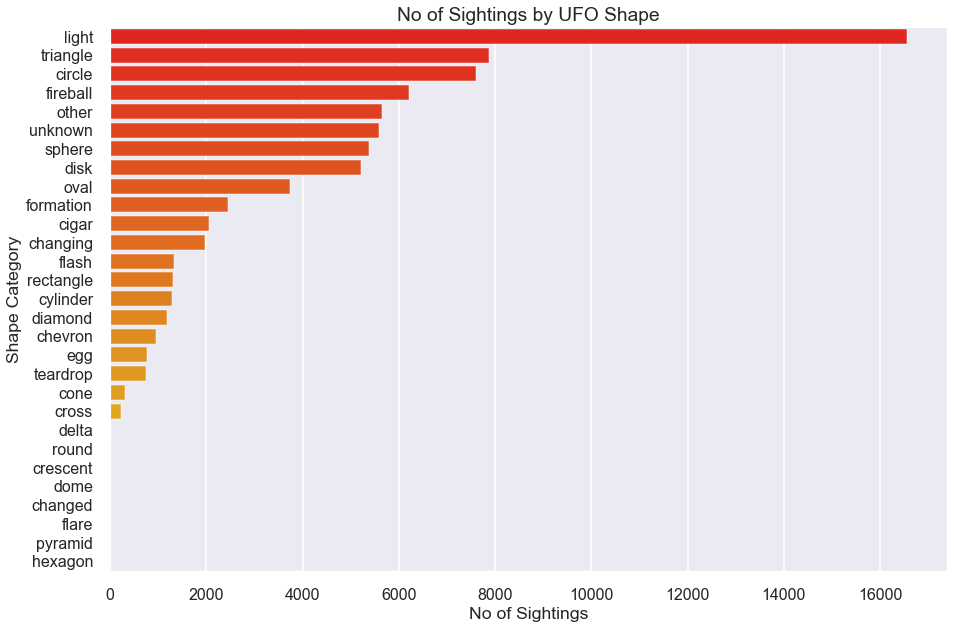

In [12]:
# create count plot of shape categories
plt.figure(figsize=(15, 10))
count = sns.countplot(y=ufos['shape'], data=ufos, palette="autumn", order=ufos['shape'].value_counts().index)
plt.xlabel('No of Sightings')
plt.ylabel('Shape Category')
plt.title('No of Sightings by UFO Shape')

#### Observations:
- The most common description of the UFO sightings is 'light', followed by triangle and then circle.
- The word 'formation' appears suggesting that for some sightings there could be more than one craft or object. 

## Duration of Sighting by Category

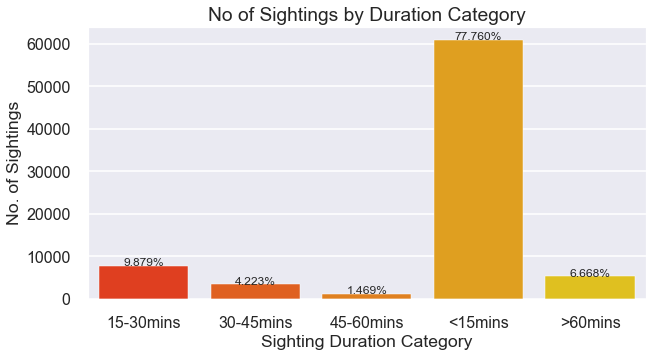

In [13]:
# create count plot of duration categories
plt.figure(figsize=(10, 5))
count = sns.countplot(x=ufos['timecategory'], data=ufos, palette="autumn")
plt.xlabel('Sighting Duration Category')
plt.ylabel('No. of Sightings')
plt.title('No of Sightings by Duration Category')
# calculate and display %
total = len(ufos)
for p in count.patches:
    height = p.get_height()
    count.text(p.get_x()+p.get_width()/2.,
               height + 3,
               '{:0.3%}'.format(height/total),
               ha="center")

#### Observations
- Sightings are generally short with approximately 93% of sightings lasting for less than 1 hour.
- The majority of these sightings last for fewer than 15 minutes (77.76%)
- 6.67% of sightings last longer than 60 minutes.

## Duration of Sightings by Country

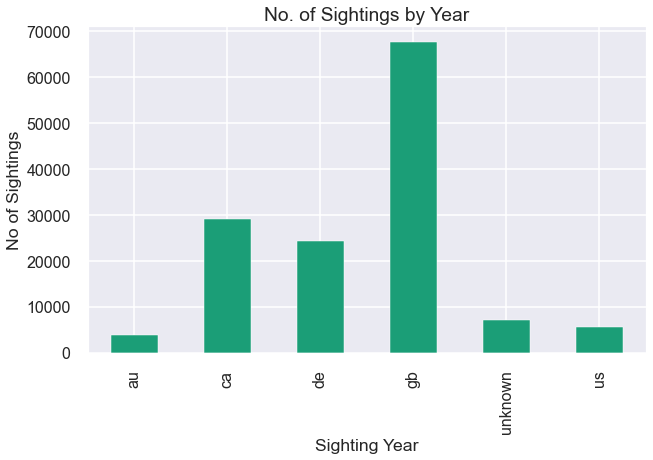

In [14]:
# group by year and count ratings per year
df = (ufos.sort_values(by='country',ascending=False).
      groupby(['country'])['duration (seconds)'].mean())
# create plot of release years & ratings
sns.set()
style.use('seaborn-poster')
plt.figure(figsize=(10, 5))
df.plot(kind='bar', colormap='Dark2', figsize=(10, 6))
plt.title('No. of Sightings by Year')
plt.xlabel('Sighting Year')
plt.ylabel('No of Sightings')
plt.show()

#### Observations:
- Great Britain appears to have the longest duration sightings on average, followed by Canada and Germany.
- The US and Australia have the shortest duration sightings on average.

## Exploring Sighting Comments 
### Comment Length By Country

Intuitively, as the comments/postings are written in English, it is a fair assumption that postings from countries with English as the first language could be longer overall. Let's Explore the Character length of comments by country.

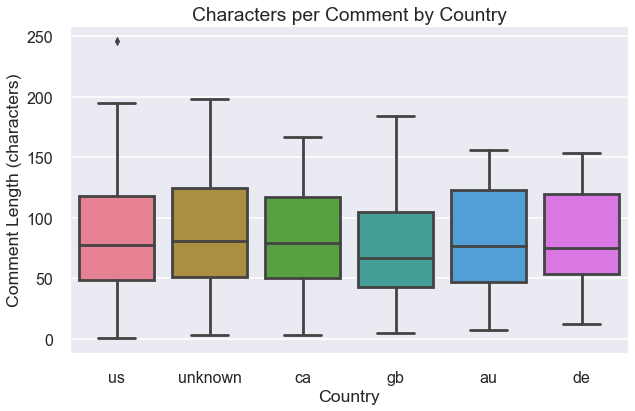

In [15]:
# create boxplot of characters per post by country
plt.figure(figsize=(10, 6))
sns.boxplot(x=ufos['country'],
            y=ufos['characters'],
            data=ufos,
            palette="husl")

plt.title('Characters per Comment by Country')
plt.xlabel('Country')
plt.ylabel('Comment Length (characters)');

In [16]:
ufos.groupby('country').characters.describe()

,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
au,527.0,82.049336,40.056631,7.0,47.0,77.0,123.0,156.0
ca,2955.0,82.488663,38.401208,3.0,50.0,79.0,117.5,167.0
de,103.0,83.601942,40.037321,12.0,54.0,75.0,119.5,154.0
gb,1855.0,74.473854,39.056624,5.0,43.0,67.0,105.0,184.0
unknown,9399.0,84.667518,39.859156,3.0,51.0,81.0,125.0,198.0
us,63561.0,82.285663,38.614941,1.0,49.0,78.0,118.0,246.0


#### Observations:
- Great Britain has the lowest average comment count per comment (74 characters per comment). This perhaps indicates that the good old Brit's are more concise and economical in their word use. 
- The remaining countries range between 82-84 characters per comment.

### Word Frequency

In [17]:
# create stop words list
stopwords_n = stopwords.words('english')
# update stop words list 
stopwords_n.extend(['unknown', 'the']) 

In [18]:
# generate word cloud for all comments
all_comms = WordCloud(max_font_size=500,
                     background_color="black",
                     width=1600,
                     height=800,
                     collocations=False,
                     stopwords=stopwords_n,
                     max_words=100,
                     colormap='Pastel1').generate(" ".join
                                               (word for word in ufos.clean_comment))

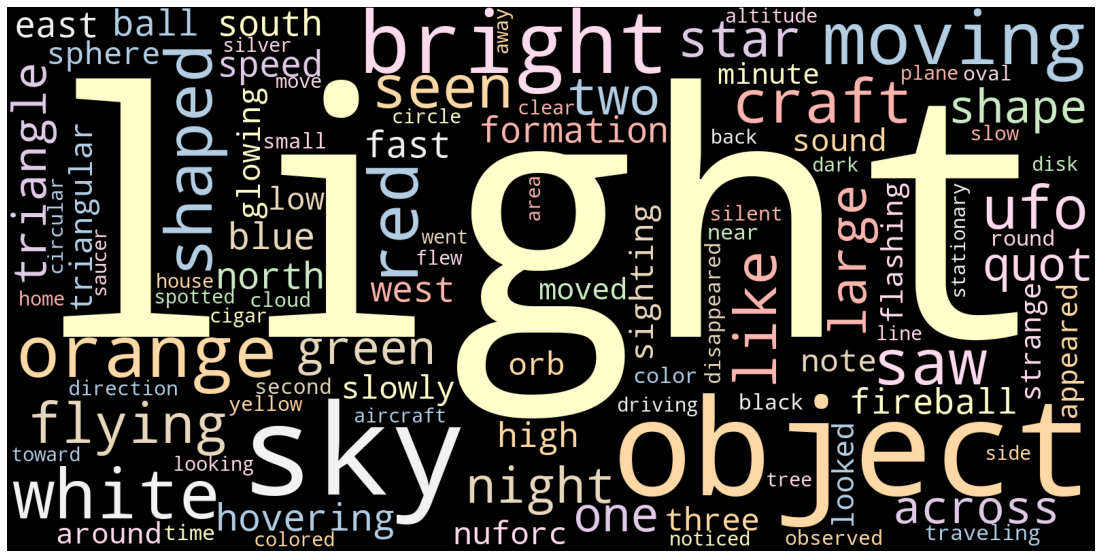

In [19]:
plt.figure(figsize=(20,10))
plt.imshow(all_comms) 
plt.axis('off') 
plt.show()

#### Observations
- The most frequently appearing word is 'light' which ties in to the most common description of the ufo sighting in the shape category. Shapes described reflect the shape category variable.
- Sightings typically describe a bright light moving in the sky. 
- The most prevalent colours of ufos are 'white', 'red' and 'orange'. Silver, green, blue, yellow and black objects are also described.
- Motion of the objects is decribed as 'hovering', 'silent', both 'slow' and 'fast' and occurs in all directions (no prevalent direction of travel judging by the size of the words 'north', 'south', 'east' and 'west'.

## Sightings by Month

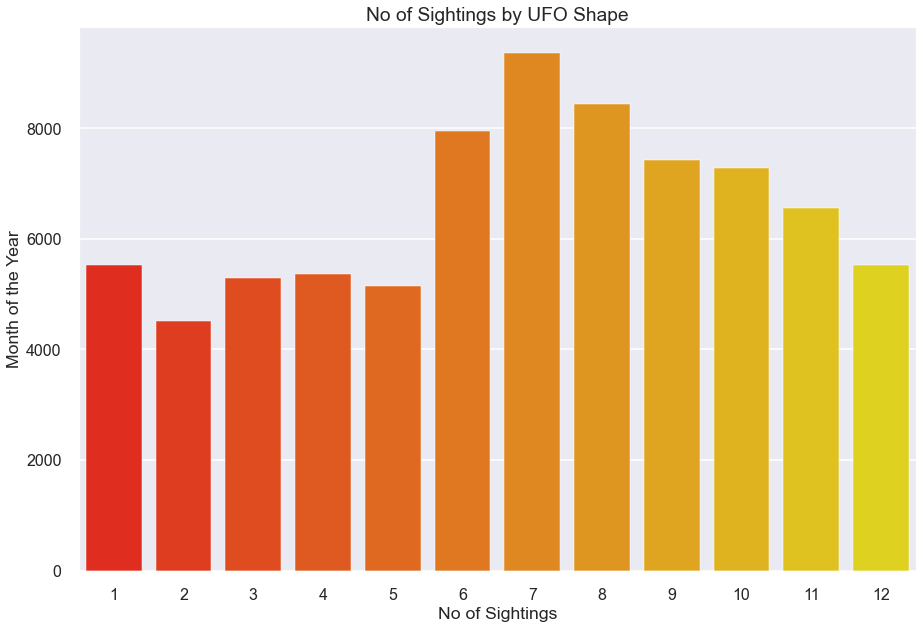

In [20]:
# create count plot of sighting months
plt.figure(figsize=(15, 10))
count = sns.countplot(x=ufos['sighting_month'], data=ufos, palette="autumn")
plt.xlabel('No of Sightings')
plt.ylabel('Month of the Year')
plt.title('No of Sightings by UFO Shape');

#### Observations:

- Sightings peak in July and are the lowest in February.
- The months of June, July and August have the highest number of sightings (summer months in the Northern hemisphere).
- As there is a concentration of sightings in the Northern hemisphere, we can deduce that summer months result in more sightings being reported potentially because of optimal weather conditions, better visibility and more people frequenting the great outdoors/travelling both day and night.